Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# MONAI Fetal Planes Classification Tutorial

This tutorial demonstrates how to use MONAI for medical image classification on the **FETAL_PLANES_DB** dataset.

**Dataset**: Fetal ultrasound plane classification (6 classes: Abdomen, Brain, Femur, Thorax, Cervix, Other)
**Task:** Classification

**Dataset Link**: [https://zenodo.org/records/3904280](https://zenodo.org/records/3904280)

**Dataset Journal Article**: [Evaluation of deep convolutional neural networks for automatic classification of common maternal fetal ultrasound planes](https://www.nature.com/articles/s41598-020-67076-5)

This tutorial covers:
1. Downloading the dataset.
2. Importing the required libraries
3. How to use the dataset with MONAI Dataloaders and Datasets.
4. Data transforms for training and validation
5. Model setup for classification
6. Training loop with validation
7. Visualization of results
8. Model evaluation

In [1]:
# Install required packages
!pip install monai[all]

## 1. Downloading Dataset

In [1]:
import os
import zipfile
from pathlib import Path

DATASET_URL = "https://zenodo.org/records/3904280/files/FETAL_PLANES_ZENODO.zip?download=1"
ZIP_FILE_NAME = "fetal_planes.zip"
dataset_folder = Path("data/fetal_planes")

if os.path.exists(ZIP_FILE_NAME) or dataset_folder.exists():
    print("Dataset already exists (zip file or extracted folder found). Skipping download.")
else:
    !wget {DATASET_URL} -O {ZIP_FILE_NAME}
    print("Dataset downloaded successfully!")

Dataset already exists (zip file or extracted folder found). Skipping download.


Extracting the downloaded dataset zip file to data/fetal_planes

In [ ]:
# Check if folder already exists
if dataset_folder.exists():
    print("Dataset folder already exists. Skipping extraction.")
elif os.path.exists(ZIP_FILE_NAME):
    # Create data directory if it doesn't exist
    dataset_folder.parent.mkdir(parents=True, exist_ok=True)
    
    # Extract to data/fetal_planes
    with zipfile.ZipFile(ZIP_FILE_NAME, 'r') as zip_ref:
        zip_ref.extractall(dataset_folder.parent)
    print("Dataset extracted successfully to data/fetal_planes!")
else:
    print("Zip file not found. Please download the dataset first.")

Dataset folder already exists. Skipping extraction.


# 2. Importing the required libraries

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# MONAI imports
from monai.data import Dataset, DataLoader
from monai.transforms import (
    Compose,
    LoadImage,
    EnsureChannelFirst,
    Resize,
    ScaleIntensityRange,
    NormalizeIntensity,
    EnsureType
)
from monai.networks.nets import EfficientNetBN
from monai.utils import set_determinism
set_determinism(seed=42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Using device: cuda


## 3. MONAI Dataloaders and Datasets

## Dataset Loading and Splitting

In [ ]:
data_dir = Path("data/fetal_planes")
csv_path = data_dir / "FETAL_PLANES_DB_data.csv"

df = pd.read_csv(csv_path, sep=';')

# The CSV file has a space in the 'Train ' column name, so we trim it to 'Train' only
if 'Train ' in df.columns:
    df.rename(columns={'Train ': 'Train'}, inplace=True)

classes = sorted(df['Plane'].unique())
num_classes = len(classes)
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

print(f"Number of classes: {num_classes}")
print(f"Classes: {classes}")
print(f"\nTotal samples: {len(df)}")
print(f"\nTrain/Test split:")
print(df['Train'].value_counts())

Number of classes: 6
Classes: ['Fetal abdomen', 'Fetal brain', 'Fetal femur', 'Fetal thorax', 'Maternal cervix', 'Other']

Total samples: 12400

Train/Test split:
Train
1    7129
0    5271
Name: count, dtype: int64


In [ ]:
df.head()

,Image_name,Patient_num,Plane,Brain_plane,Operator,US_Machine,Train
0,Patient00001_Plane1_1_of_15,1,Other,Not A Brain,Other,Aloka,1
1,Patient00001_Plane1_2_of_15,1,Other,Not A Brain,Other,Aloka,1
2,Patient00001_Plane1_3_of_15,1,Other,Not A Brain,Other,Aloka,1
3,Patient00001_Plane1_4_of_15,1,Other,Not A Brain,Other,Aloka,1
4,Patient00001_Plane1_5_of_15,1,Other,Not A Brain,Other,Aloka,1


Adding column `image_path` and `class_idx` to the dataframe

In [ ]:
# Create image paths and labels
df['image_path'] = df['Image_name'].apply(lambda x: str(data_dir / "Images" / f"{x}.png"))
df['class_idx'] = df['Plane'].map(class_to_idx)

Some of the images in the dataset are not grayscale and will cause errors in the training process, so we need to filter them out.

In [ ]:
from PIL import Image

problematic_indices = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    image_path = row['image_path']
    image = Image.open(image_path)
    if image.mode != 'L':
        problematic_indices.append(idx)

print(f"Found {len(problematic_indices)} problematic images")

# Remove problematic images from dataframe
df = df.drop(problematic_indices)

# Reset index
df = df.reset_index(drop=True)

100%|██████████| 12400/12400 [00:01<00:00, 10785.31it/s]

Found 45 problematic images


Split into train and validation based on 'Train' column. Train=1 means training set, Train=0 means test set

In [ ]:
train_df = df[df['Train'] == 1].copy()
val_df = df[df['Train'] == 0].copy()

# Filter out Patient 1 (has 4-channel RGBA images instead of grayscale)
train_df = train_df[train_df['Patient_num'] != 1].copy()
val_df = val_df[val_df['Patient_num'] != 1].copy()

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"\nClass distribution in training set:")
print(train_df['Plane'].value_counts())

Training samples: 7114
Validation samples: 5235

Class distribution in training set:
Plane
Other              2586
Fetal brain        1620
Fetal thorax       1058
Maternal cervix     981
Fetal femur         516
Fetal abdomen       353
Name: count, dtype: int64


In [ ]:
# Create a MONAI-compatible Dataset class
class FetalPlanesDataset(Dataset):
    """
    Custom dataset class for fetal planes classification.
    Returns dictionary with 'image' and 'label' keys for MONAI compatibility.
    """
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        
        data = {"image_path": image_path}

        # Apply transforms if provided
        if self.transform:
            data["image"] = self.transform(data["image_path"])
        
        # Ensure label is a tensor
        data['label'] = torch.tensor(label, dtype=torch.long)
        
        return data

## 4. Data Transforms for Training and Validation

In [ ]:
train_transforms = Compose([
    LoadImage(reverse_indexing=False),  # For image files setting reverse_indexing to False to False will prevent the image from being transposed
    EnsureChannelFirst(),
    Resize(spatial_size=(224, 224)),
    ScaleIntensityRange(a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0),
    NormalizeIntensity(subtrahend=[0.445], divisor=[0.269], channel_wise=True),  # ImageNet normalization (grayscale)
    EnsureType(data_type="tensor")
])

In [ ]:
val_transforms = Compose([
    LoadImage(reverse_indexing=False),
    EnsureChannelFirst(),
    Resize(spatial_size=(224, 224)),
    ScaleIntensityRange(a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0),
    NormalizeIntensity(subtrahend=[0.445], divisor=[0.269], channel_wise=True),
    EnsureType(data_type="tensor")
])

In [ ]:
train_dataset = FetalPlanesDataset(
    image_paths=train_df['image_path'].tolist(),
    labels=train_df['class_idx'].tolist(),
    transform=train_transforms
)

val_dataset = FetalPlanesDataset(
    image_paths=val_df['image_path'].tolist(),
    labels=val_df['class_idx'].tolist(),
    transform=val_transforms
)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training batches: 223
Validation batches: 164


## 5. Classification Model Setup

In [ ]:
model = EfficientNetBN(
    model_name="efficientnet-b0",
    spatial_dims=2,
    in_channels=1,
    num_classes=num_classes,
    pretrained=True
).to(device)

print(f"Model: DenseNet121")
print(f"Input channels: 1 (grayscale)")
print(f"Output channels: {num_classes} (classes)")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Model: DenseNet121
Input channels: 1 (grayscale)
Output channels: 6 (classes)
Total parameters: 4,014,658


## 6. Training Loop with Validation

In [ ]:
criterion = nn.CrossEntropyLoss()

lr = 1e-3
warmup_epochs = 3
num_epochs = 10

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)


train_losses = []
val_losses = []
val_accuracies = []
learning_rates = []
best_val_acc = 0.0
model_path = "best_model.pth" # Path to save the best model

In [ ]:
for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0
    
    for batch in tqdm(train_loader):
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_acc:
        print(f"New best validation accuracy: {val_accuracy:.2f}%")
        print(f"Saving model to {model_path}")
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), model_path)
    
    warmup_status = f" (Warm-up)" if epoch < warmup_epochs else ""
    print(f"Epoch [{epoch+1}/{num_epochs}]{warmup_status}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}")
    print(f"  Val Accuracy: {val_accuracy:.2f}%")
    print("-" * 50)

100%|██████████| 164/164 [00:10<00:00, 16.05it/s]


Epoch [1/10] (Warm-up)
  Train Loss: 0.4509
  Val Loss: 4.2966
  Val Accuracy: 39.89%
--------------------------------------------------


100%|██████████| 164/164 [00:10<00:00, 16.06it/s]


Epoch [2/10] (Warm-up)
  Train Loss: 0.2471
  Val Loss: 0.6978
  Val Accuracy: 76.29%
--------------------------------------------------


100%|██████████| 164/164 [00:10<00:00, 16.07it/s]


Epoch [3/10] (Warm-up)
  Train Loss: 0.1480
  Val Loss: 0.5932
  Val Accuracy: 83.80%
--------------------------------------------------


100%|██████████| 164/164 [00:10<00:00, 16.19it/s]


Epoch [4/10]
  Train Loss: 0.0952
  Val Loss: 0.3187
  Val Accuracy: 90.96%
--------------------------------------------------


100%|██████████| 164/164 [00:10<00:00, 16.20it/s]


Epoch [5/10]
  Train Loss: 0.0793
  Val Loss: 0.3868
  Val Accuracy: 90.30%
--------------------------------------------------


100%|██████████| 164/164 [00:10<00:00, 16.04it/s]


Epoch [6/10]
  Train Loss: 0.0730
  Val Loss: 0.4815
  Val Accuracy: 87.87%
--------------------------------------------------


100%|██████████| 164/164 [00:10<00:00, 16.02it/s]


Epoch [7/10]
  Train Loss: 0.0991
  Val Loss: 0.3980
  Val Accuracy: 91.06%
--------------------------------------------------


100%|██████████| 164/164 [00:10<00:00, 16.13it/s]


Epoch [8/10]
  Train Loss: 0.0570
  Val Loss: 0.3291
  Val Accuracy: 92.36%
--------------------------------------------------


100%|██████████| 164/164 [00:10<00:00, 16.07it/s]


Epoch [9/10]
  Train Loss: 0.0606
  Val Loss: 0.3397
  Val Accuracy: 90.58%
--------------------------------------------------


100%|██████████| 164/164 [00:10<00:00, 16.07it/s]

Epoch [10/10]
  Train Loss: 0.0470
  Val Loss: 0.5449
  Val Accuracy: 88.83%
--------------------------------------------------


## 7. Visualization of Results

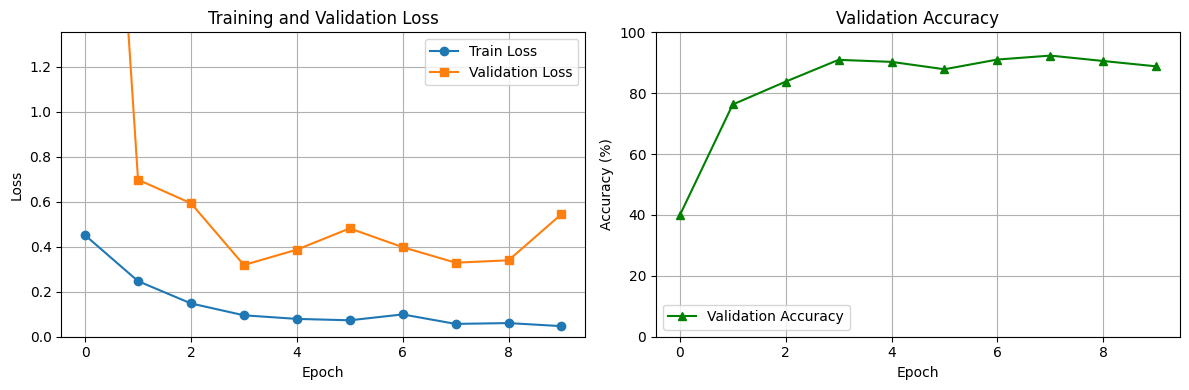

In [ ]:
# Plot loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 3*train_losses[0])
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', marker='^', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

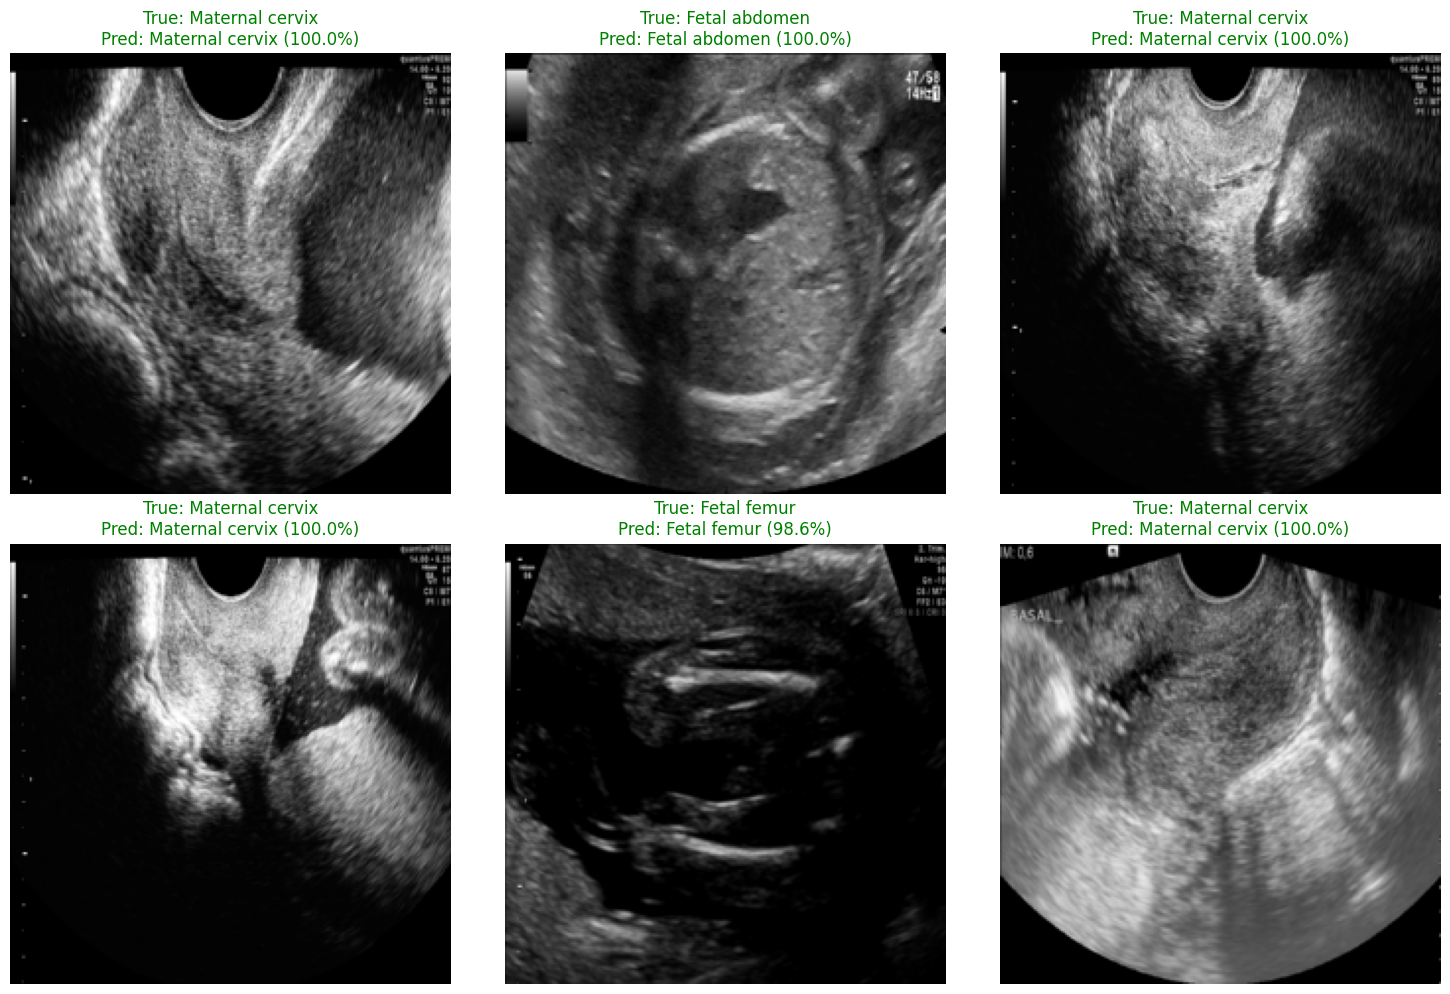

In [ ]:
model.load_state_dict(torch.load(model_path))
model.eval()
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

import random

rand_indices = random.sample(range(len(val_dataset)), 6)
samples = [val_dataset[i] for i in rand_indices]

images = torch.stack([s['image'] for s in samples]).to(device)
labels = torch.tensor([s['label'] for s in samples])

with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    probabilities = torch.softmax(outputs, dim=1)

for i in range(6):
    img = images[i].cpu().squeeze().numpy()
    true_label = classes[labels[i].item()]
    pred_label = classes[predicted[i].item()]
    confidence = probabilities[i][predicted[i]].item() * 100
    
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)', 
                      color='green' if true_label == pred_label else 'red')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 8. Model Evaluation

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_accuracy = accuracy_score(all_labels, all_preds)
print(f"Final Validation Accuracy: {final_accuracy * 100:.2f}%")

Final Validation Accuracy: 92.36%


In [ ]:
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))


Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.85      0.94      0.89       358
    Fetal brain       0.99      0.98      0.98      1472
    Fetal femur       0.88      0.82      0.85       524
   Fetal thorax       0.90      0.91      0.91       660
Maternal cervix       0.98      1.00      0.99       637
          Other       0.88      0.88      0.88      1584

       accuracy                           0.92      5235
      macro avg       0.91      0.92      0.92      5235
   weighted avg       0.92      0.92      0.92      5235



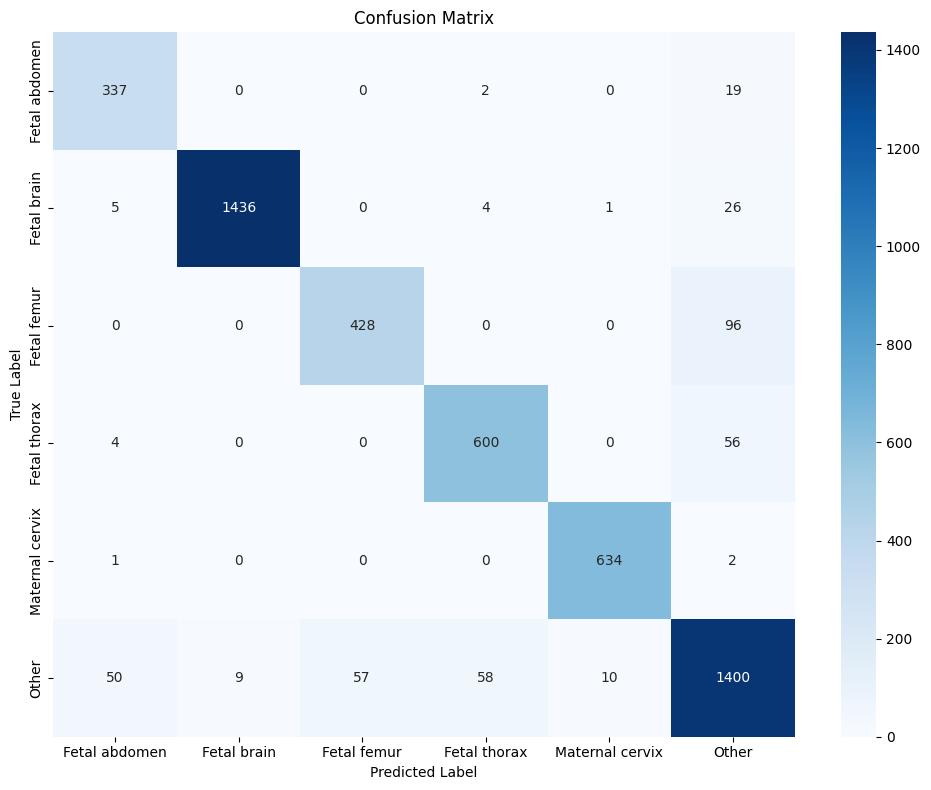

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()